In [3]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, auc, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X_resnet = pd.read_csv('data/train/resnet_train_features.csv', header=None, index_col=0)
X_overfeat = pd.read_csv('data/train/overfeat_train_features.csv', header=None, index_col=0)
X_vgg = pd.read_csv('data/train/vgg_train_features.csv', header=None, index_col=0)

X = X_resnet.join(X_overfeat, lsuffix='_resnet', rsuffix='_overfeat').join(X_vgg, rsuffix='_vgg')
y = np.array([0 if x.startswith('cat') else 1 for x in X.index])
del X_resnet, X_overfeat, X_vgg

In [5]:
X_test_resnet = pd.read_csv('data/test/resnet_test_features.csv', header=None, index_col=0)
X_test_overfeat = pd.read_csv('data/test/overfeat_test_features.csv', header=None, index_col=0)
X_test_vgg = pd.read_csv('data/test/vgg_test_features.csv', header=None, index_col=0)

X_test = X_test_resnet.join(X_test_overfeat, lsuffix='_resnet', rsuffix='_overfeat').join(X_test_vgg, rsuffix='_vgg')
del X_test_resnet, X_test_overfeat, X_test_vgg

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=3000)
X_train.shape, y_train.shape

((22000, 9192), (22000,))

## Random Forest

In [7]:
clf = RandomForestClassifier(
    n_estimators=120,
    max_depth=12,
    warm_start=True,
    n_jobs=4, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   31.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=4, oob_score=False, random_state=None,
            verbose=1, warm_start=True)

In [8]:
y_pred = clf.predict(X_val)

print('Accuracy:\t%.4f' % accuracy_score(y_val, y_pred))
print('Precition:\t%.4f' % precision_score(y_val, y_pred))
print('Recall:\t\t%.4f' % recall_score(y_val, y_pred))
print('F1-score:\t%.4f' % f1_score(y_val, y_pred))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.1s finished


Accuracy:	0.9977
Precition:	0.9973
Recall:		0.9979
F1-score:	0.9976


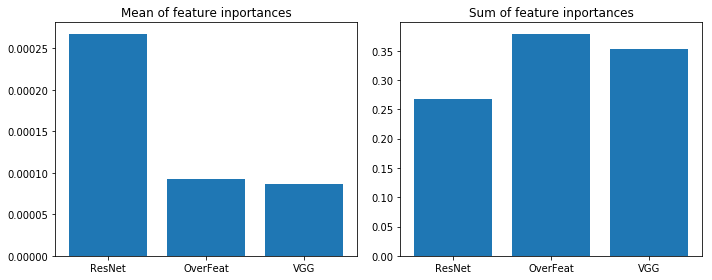

In [24]:
feature_imps = [
    clf.feature_importances_[:1000], 
    clf.feature_importances_[1000:5096], 
    clf.feature_importances_[5096:]
]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Mean of feature inportances')
plt.bar((0,1,2), [np.mean(x) for x in feature_imps])
plt.xticks((0,1,2), ('ResNet', 'OverFeat', 'VGG'))

plt.subplot(1,2,2)
plt.title('Sum of feature inportances')
plt.bar((0,1,2), [np.sum(x) for x in feature_imps])
plt.xticks((0,1,2), ('ResNet', 'OverFeat', 'VGG'))
plt.tight_layout()

In [23]:
y_pred = pd.DataFrame(clf.predict(X_test), columns=['label'], index=X_test.index)
y_pred[y_pred['label'] == 0] = 'cat'
y_pred[y_pred['label'] == 1] = 'dog'
y_pred.to_csv('agg_rf.csv', index_label='file')

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    0.1s finished


## SGD

In [27]:
# finetuned
clf = SGDClassifier(loss='hinge', penalty='l1', epsilon=1., n_jobs=4)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=1.0,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=4,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [28]:
y_pred = clf.predict(X_val)

print('Accuracy:\t%.4f' % accuracy_score(y_val, y_pred))
print('Precition:\t%.4f' % precision_score(y_val, y_pred))
print('Recall:\t\t%.4f' % recall_score(y_val, y_pred))
print('F1-score:\t%.4f' % f1_score(y_val, y_pred))

Accuracy:	0.9963
Precition:	0.9966
Recall:		0.9959
F1-score:	0.9962


In [10]:
y_pred = pd.DataFrame(clf.predict(X_test), columns=['label'], index=X_test.index)
y_pred[y_pred['label'] == 0] = 'cat'
y_pred[y_pred['label'] == 1] = 'dog'
y_pred.to_csv('agg_sgd.csv', index_label='file')

## Neural Network

In [7]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import BatchNormLayer
from lasagne.layers import DropoutLayer
from lasagne.nonlinearities import softmax, sigmoid

# finetuned
def build_model():
    net = {}
    net['input'] = InputLayer((None, 9192))
    net['fc1'] = DenseLayer(net['input'], num_units=512, nonlinearity=None)
    net['bn1'] = BatchNormLayer(net['fc1'])
    net['nl1'] = NonlinearityLayer(net['bn1'], sigmoid)
    net['fc1_dropout'] = DropoutLayer(net['nl1'], p=0.5)
    net['fc2'] = DenseLayer(net['fc1_dropout'], num_units=32, nonlinearity=None)
    net['bn2'] = BatchNormLayer(net['fc2'])
    net['nl2'] = NonlinearityLayer(net['bn2'], sigmoid)
    net['fc2_dropout'] = DropoutLayer(net['nl2'], p=0.5)
    net['fc3'] = DenseLayer(net['fc2_dropout'], num_units=2, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc3'], softmax)

    return net

# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X.loc[X.index[batch_idx]], Y[batch_idx]

In [8]:
input_var = T.matrix('inputs')
target_var = T.ivector('targets')
learning_rate = T.scalar(name='learning_rate')

net = build_model()

prediction = lasagne.layers.get_output(net['prob'], input_var)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var).mean()

params = lasagne.layers.get_all_params(net['prob'], trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=learning_rate)

In [9]:
test_prediction = lasagne.layers.get_output(net['prob'], input_var, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),dtype=theano.config.floatX)

In [10]:
train_fn = theano.function([input_var, target_var, learning_rate], loss, updates=updates, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)
predict = theano.function([input_var], test_prediction, allow_input_downcast=True)

In [14]:
import time 
import sys
num_epochs = 10
lr = 1e-5
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in get_batches((X_train, y_train), 5500):
        inputs, targets = batch
        train_err += train_fn(inputs, targets, lr)
        train_batches += 1
        print '.', 
        sys.stdout.flush()
    
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in get_batches((X_val, y_val), 500):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

#     # Then we print the results for this epoch:
#     if epoch % 5 == 0: 
    print("\nEpoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  loss:\t\t\t{:.6f},{:.6f}".format(train_err / train_batches, val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    sys.stdout.flush()

. . . . 
Epoch 1 of 10 took 23.008s
  loss:			0.203556,0.132338
  validation accuracy:		99.73 %
. . . . 
Epoch 2 of 10 took 22.347s
  loss:			0.203587,0.132511
  validation accuracy:		99.73 %
. . . . 
Epoch 3 of 10 took 20.545s
  loss:			0.204067,0.132619
  validation accuracy:		99.73 %
. . . . 
Epoch 4 of 10 took 20.074s
  loss:			0.204315,0.132580
  validation accuracy:		99.73 %
. . . . 
Epoch 5 of 10 took 19.804s
  loss:			0.203943,0.132632
  validation accuracy:		99.73 %
. . . . 
Epoch 6 of 10 took 20.344s
  loss:			0.204714,0.132611
  validation accuracy:		99.73 %
. . . . 
Epoch 7 of 10 took 19.762s
  loss:			0.203925,0.132535
  validation accuracy:		99.73 %
. . . . 
Epoch 8 of 10 took 20.779s
  loss:			0.206117,0.132402
  validation accuracy:		99.73 %
. . . . 
Epoch 9 of 10 took 20.840s
  loss:			0.204838,0.132458
  validation accuracy:		99.73 %
. . . . 
Epoch 10 of 10 took 20.168s
  loss:			0.202131,0.132383
  validation accuracy:		99.73 %


In [15]:
y_true, y_pred = [], []
for batch in get_batches((X_train, y_train), 500):
    inputs, targets = batch
    y_pred.extend((predict(inputs)[:,1] > 0.5).astype(int))
    y_true.extend(targets)
print('Train: %.4f %.4f %.4f %.4f' %\
      (accuracy_score(y_true, y_pred),\
       precision_score(y_true, y_pred),\
       recall_score(y_true, y_pred),\
       f1_score(y_true, y_pred)))

y_true, y_pred = [], []
for batch in get_batches((X_val, y_val), 500):
    inputs, targets = batch
    y_pred.extend((predict(inputs)[:,1] > 0.5).astype(int))
    y_true.extend(targets)
    
print('Valid: %.4f %.4f %.4f %.4f' %\
      (accuracy_score(y_true, y_pred),\
       precision_score(y_true, y_pred),\
       recall_score(y_true, y_pred),\
       f1_score(y_true, y_pred)))

Train: 0.9970 0.9967 0.9975 0.9971
Valid: 0.9973 0.9952 0.9993 0.9973


In [16]:
y_pred = pd.DataFrame(predict(X_test)[:,1] > 0.5, columns=['label'], index=X_test.index)
y_pred[y_pred['label'] == False] = 'cat'
y_pred[y_pred['label'] == True] = 'dog'
y_pred.to_csv('agg_nn.csv', index_label='file')

### XGBoost

In [5]:
import xgboost

# finetuned
clf = xgboost.XGBClassifier(
        max_depth=5, 
        subsample=0.5,
        colsample_bytree = 0.3,
        n_estimators=250,
        objective='binary:logistic', nthread=2)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=250, nthread=2,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

In [6]:
y_pred = clf.predict(X_val)

print('Accuracy:\t%.4f' % accuracy_score(y_val, y_pred))
print('Precition:\t%.4f' % precision_score(y_val, y_pred))
print('Recall:\t\t%.4f' % recall_score(y_val, y_pred))
print('F1-score:\t%.4f' % f1_score(y_val, y_pred))

Accuracy:	0.9977
Precition:	0.9973
Recall:		0.9979
F1-score:	0.9976


In [20]:
y_pred = pd.DataFrame(clf.predict(X_test), columns=['label'], index=X_test.index)
y_pred[y_pred['label'] == 0] = 'cat'
y_pred[y_pred['label'] == 1] = 'dog'
y_pred.to_csv('agg_xgbst.csv', index_label='file')